### Abstract

We present a study on using machine learning to classify stars using machine learning and Recursive Feature Elimination (RFE). RFE is a feature selection method that aims to identify the most relevant features for a given classification task. We propose a supervised learning approach that combines RFE with ML algorithms (Random Forest and SVM) to classify stars according to their spectral types. We used datasets of labeled stellar spectra to train and test our model. Our experimental results showed that the proposed method with RFE improved the performance of the model in terms of classification accuracy and computational efficiency. This research illustrates the potential of using RFE as a feature selection method in combination with machine learning algorithms to improve the performance of classification tasks of star types. This tool is expected to be especially beneficial as it allows for quicker classification of a large number of objects compared to the traditional classification methods.

Import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.features import RadViz
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy import stats



## EDA

In [3]:
star_df = pd.read_csv("training_data.csv")
star_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74282 entries, 0 to 74281
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subCl        74282 non-null  object 
 1   Gmag         74282 non-null  float64
 2   TargetClass  74282 non-null  int64  
 3   r_umag       74282 non-null  float64
 4   r_gmag       74282 non-null  float64
 5   r_rmag       74282 non-null  float64
 6   r_imag       74282 non-null  float64
 7   r_zmag       74282 non-null  float64
 8   r_Gmag       74282 non-null  float64
 9   r_BPmag      74282 non-null  float64
 10  r_RPmag      74282 non-null  float64
 11  bp-rp        74282 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 6.8+ MB


Train-test Split

In [4]:
stars_num = star_df.drop('subCl', inplace=False, axis='columns')


In [5]:
df_train, df_test = train_test_split(stars_num, test_size=0.2, random_state=321)
X_train = df_train.drop(columns=["TargetClass"])
Y_train = df_train["TargetClass"]
X_test = df_test.drop(columns=["TargetClass"])
Y_test = df_test["TargetClass"]

<AxesSubplot:>

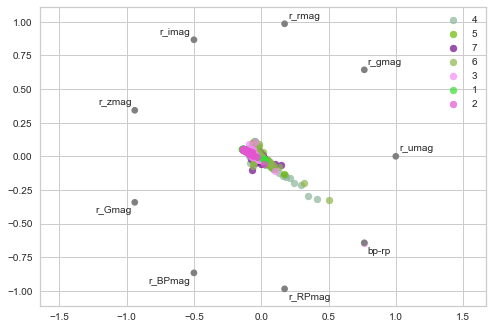

In [6]:
pd.plotting.radviz(df_train, 'TargetClass', alpha = 0.7)

## Method - Data Analysis: Principle Complenet Analysis

- PCA reduces the dimensionality of the data by identifying the most important features that contribute to the variance in the dataset. 
- Visualization of data in a lower-dimensional space shows the existance of a relationship between the star's magnitude its spectral type
- It suggests that machine learning models have the potential to classify the spectral type of stars.

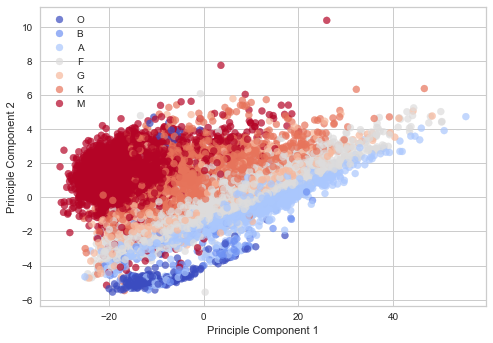

In [12]:
from sklearn.decomposition import PCA
features = ['r_umag',	'r_gmag',	'r_rmag',	'r_imag',	'r_zmag',	'r_Gmag',	'r_BPmag',	'r_RPmag',	'bp-rp']
pca = PCA(n_components=2)
# Fit the PCA model to your data
pca.fit(df_train[features])
transformed_data = pca.transform(df_train[features])

num_classes = len(Y_train.unique())
cmap = plt.cm.get_cmap('hsv', num_classes)

class_labels = ['O', 'B', 'A','F','G','K','M'] 

# Plot the transformed data using scatter plot
scatter = plt.scatter(transformed_data[:,0], transformed_data[:,1],c=Y_train, cmap='coolwarm', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.show()

## Feature Engineering: 
- Reason we need that: When working with large dataset, we want to reduce the computational complexity and storage requirements of the classification model

- Recursive feature selection illustrated with Random Forest

    - At first, validation score increase as number of feature increase. It reaches maximum at 5 features and slowly decrease after it, which showed that the decision tree classifier performs best when using only 5 features.

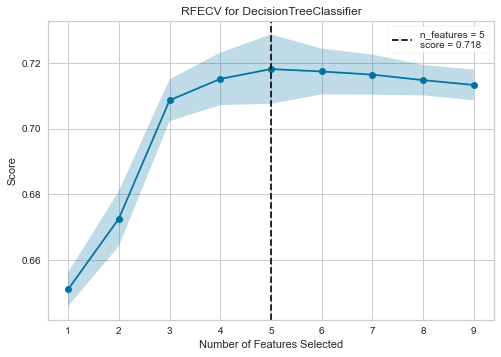

RFECV(ax=<AxesSubplot:title={'center':'RFECV for DecisionTreeClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>,
      estimator=DecisionTreeClassifier())

In [76]:
from yellowbrick.model_selection import RFECV
visualizer = RFECV(DecisionTreeClassifier())
visualizer.fit(X_train, Y_train)        # Fit the data to the visualizer
visualizer.show()

## Result: Model Comparing (Confusion matrix on test data)
- Support Vector Machine (RBF kernel) with Scaling and Random Search

In [13]:
pipe_svm = make_pipeline(StandardScaler(), SVC())  # We need scaling for SVM RBF
pipe_svm.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [80]:
cv_scores_svm = cross_val_score(pipe_svm, X_train, Y_train, cv=2)
pd.DataFrame(cv_scores_svm)

,0
0,0.783374
1,0.784945


In [81]:
param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
}

In [82]:
random_search = RandomizedSearchCV(
    pipe_svm, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=2, random_state=321
)
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   n_jobs=-1,
                   param_distributions={'svc__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                   100, 1000],
                                        'svc__gamma': [0.001, 0.01, 0.1, 1.0,
                                                       10, 100, 1000]},
                   random_state=321)

In [83]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,8,8
mean_test_score,0.80755,0.799136,0.791732,0.785899,0.770137,0.753758,0.705912,0.471001,0.471001,0.471001
param_svc__gamma,0.1,0.1,10,0.001,10,10,0.01,1000,0.001,1000
param_svc__C,1000,10,1.0,100,100,1000,0.1,0.001,0.01,0.1
mean_fit_time,28.671451,6.417277,11.782896,6.760215,14.986627,33.564351,9.523536,10.563699,15.45193,24.753959


In [14]:
y_pred = random_search.predict(X_test)

# Compute precision, recall, and F1 score for each class
precision = precision_score(Y_test, y_pred, average=None)
recall = recall_score(Y_test, y_pred, average=None)
f1 = f1_score(Y_test, y_pred, average=None)

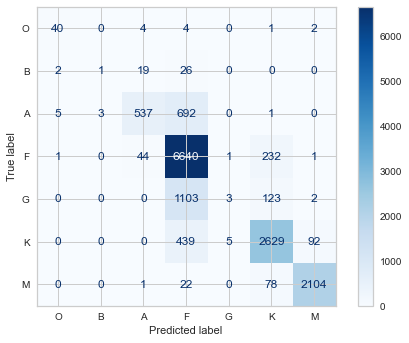

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
confusion_svm = ConfusionMatrixDisplay.from_estimator(
    pipe_svm,
    X_test,
    Y_test,
    display_labels=["O", "B","A","F", "G","K","M"],
    values_format="d",
    cmap=plt.cm.Blues,
);

- Random Forest

In [6]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.8157097664400619

Illustration of random forest


[Text(0.5555555555555556, 0.9, 'r_umag <= 7.191\ngini = 0.506\nsamples = 16\nvalue = [16, 2, 7, 0]'),
 Text(0.3333333333333333, 0.7, 'r_rmag <= 4.68\ngini = 0.231\nsamples = 9\nvalue = [13, 2, 0, 0]'),
 Text(0.2222222222222222, 0.5, 'r_rmag <= 4.135\ngini = 0.375\nsamples = 4\nvalue = [6, 2, 0, 0]'),
 Text(0.1111111111111111, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [6, 0, 0, 0]'),
 Text(0.3333333333333333, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [0, 2, 0, 0]'),
 Text(0.4444444444444444, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [7, 0, 0, 0]'),
 Text(0.7777777777777778, 0.7, 'r_zmag <= 6.975\ngini = 0.42\nsamples = 7\nvalue = [3, 0, 7, 0]'),
 Text(0.6666666666666666, 0.5, 'Gmag <= 17.331\ngini = 0.219\nsamples = 6\nvalue = [1, 0, 7, 0]'),
 Text(0.5555555555555556, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 4, 0]'),
 Text(0.7777777777777778, 0.3, 'r_BPmag <= 5.902\ngini = 0.375\nsamples = 3\nvalue = [1, 0, 3, 0]'),
 Text(0.6666666666666666, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 3, 

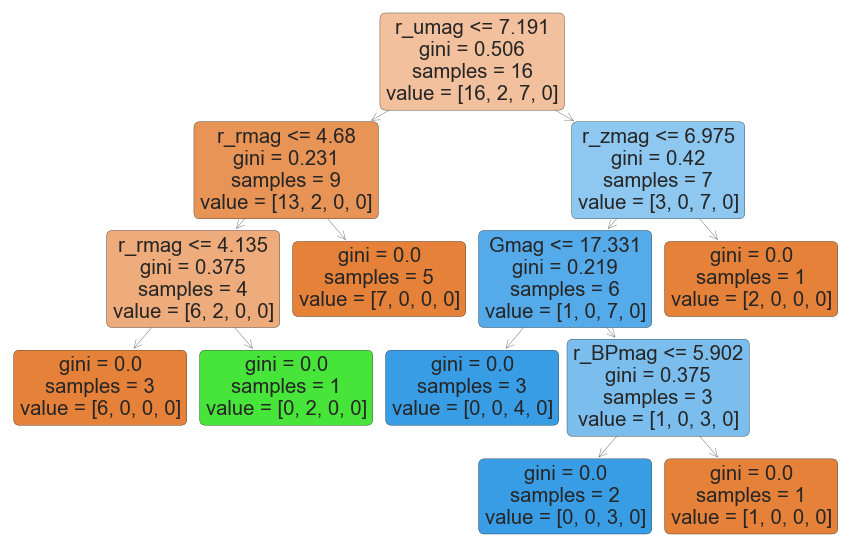

In [12]:
toy_model = RandomForestClassifier()
toy_model.fit(X_train[:25], Y_train[:25])
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(toy_model.estimators_[0], 
          feature_names=X_train.columns, 
          filled=True, impurity=True, 
          rounded=True)


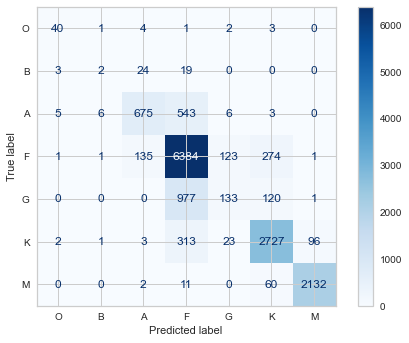

In [38]:
confusion_rf = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    Y_test,
    display_labels=["O", "B","A","F", "G","K","M"],
    values_format="d",
    cmap=plt.cm.Blues
);